In [1]:
!pip install qiskit

In [2]:
!pip install qiskit-finance

In [3]:
!pip install yfinance

In [4]:
#importing the required stuff
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, SPSA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_finance import QiskitFinanceError
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt

import datetime
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import csv
import yfinance as yf
import pandas_datareader.data as web
from qiskit_finance.applications.optimization import PortfolioDiversification

In [5]:
%matplotlib inline

In [6]:
assets = ["AAPL", "GS", "JPM", "MSFT", "MCD", "WMT"]

In [7]:
# set number of assets (= number of qubits)

seed = 123

# assets = ["JPM", "GS", "MSFT", "AAPL", "WMT", "MCD"]

# Using data from yahoo finance
# use the name listed for particular company that you wish to add

import yfinance as yf
import numpy as np
selected_stocks_data = yf.download(assets, start = '2011-01-01', end = '2015-12-31')['Adj Close']
selected_stocks_data.head()
log_return = np.log(selected_stocks_data/selected_stocks_data.shift(1))
# np.log(data/data.shift(1))
# log_return.head()


num_assets = len(assets)
mu = log_return.mean()*252
sigma = log_return.cov()*252
sigma = np.array(sigma)
mu = np.array(mu)

[*********************100%***********************]  6 of 6 completed


In [8]:
print("returns ", mu)
print("cov ", sigma)

returns  [0.18379945 0.02934704 0.11680789 0.12096646 0.16833685 0.05254239]
cov  [[0.07116694 0.02419544 0.02418426 0.01282644 0.02159661 0.01014043]
 [0.02419544 0.07076246 0.05930987 0.01574948 0.02916762 0.0151753 ]
 [0.02418426 0.05930987 0.07285128 0.01658965 0.03006861 0.01627251]
 [0.01282644 0.01574948 0.01658965 0.02290809 0.01464425 0.00917056]
 [0.02159661 0.02916762 0.03006861 0.01464425 0.05508359 0.0128899 ]
 [0.01014043 0.0151753  0.01627251 0.00917056 0.0128899  0.02625409]]


In [9]:
# mu = [0.17963223 0.02361927 0.11148807 0.12148153 0.16796828 0.05025399]
# sigma = [[0.07113697 0.02409548 0.02409281 0.01284735 0.02160622 0.01010096]
#  [0.02409548 0.07065498 0.05920492 0.01577678 0.02918024 0.01512194]
#  [0.02409281 0.05920492 0.07276795 0.01661657 0.03008277 0.01622466]
#  [0.01284735 0.01577678 0.01661657 0.02292501 0.01465683 0.00918377]
#  [0.02160622 0.02918024 0.03008277 0.01465683 0.0551268  0.01289592]
#  [0.01010096 0.01512194 0.01622466 0.00918377 0.01289592 0.02624887]]

In [10]:
# data = YahooDataProvider(
#         tickers= assets , 
#         start=datetime.datetime(2011, 1, 1),
#         end=datetime.datetime(2015, 12, 31),
#     )

# num_assets = len(assets)
# data.run()

# muu = data.get_period_return_mean_vector()
# sigmaa = data.get_period_return_covariance_matrix()
# rho = data.get_similarity_matrix()
# print(muu)
# print(sigmaa)

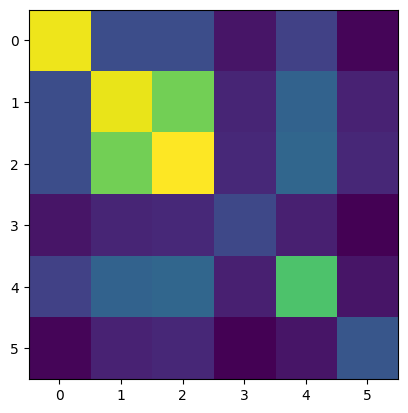

In [11]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [14]:
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget,
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.035583471628579874*x_0^2 + 0.024195439522950186*..., 6 variables, 1 constraints, 'Portfolio optimization'>

In [21]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result,fname):
    
    f = open(fname, 'w')
    header = ['SELECTION', 'VALUE', 'PROBABLITY']
    writer = csv.writer(f)
    writer.writerow(header)
    
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    # eigenstate = result.min_eigen_solver_result.eigenstate
    # eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    # probabilities = np.abs(eigenvector) ** 2
    # i_sorted = reversed(np.argsort(probabilities))
    # print("\n----------------- Full result ---------------------")
    # print("selection\tvalue\t\tprobability")
    # print("---------------------------------------------------")
    # for i in i_sorted:
    #     x = index_to_selection(i, num_assets)
    #     value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
    #     # value = portfolio.to_quadratic_program().objective.evaluate(x)
    #     probability = probabilities[i]
    #     row = [x, value, probability]
    #     writer.writerow(row)
        # print("%10s\t%.4f\t\t%.4f" % (x, value, probability))
    f.close()

In [22]:
#classical reference solution
#provide fname ='complete address/location of your .csv file'

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)
fname = 'nes1.csv' #change the location and nsame of .csv file

print_result(result,fname)


# [1. 0. 0. 1. 1. 0.]

Optimal: selection [1. 0. 0. 1. 1. 0.], value -0.3495


### [0. 0. 1. 1. 0. 1.] is the solution by Exact solver and QAOA. but for VQE it's the most probable bit string, but it doesn't gives lowest energy to this bitstring, that's why it doesn't be the optimal solution with VQE. 

In [23]:
!pip install qiskit-aer

In [24]:
# VQE with Cobyla solution
#provide fname ='complete address/location of your .csv file'

from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("qasm_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

fname = 'vqe1.csv' #change the location and name of .csv file
print_result(result, fname)



#[0. 0. 1. 1. 0. 1.] --numpy eigen solver

vqe result type  <class 'qiskit.algorithms.minimum_eigen_solvers.vqe.VQEResult'>
Optimal: selection [1. 0. 0. 1. 1. 0.], value -0.3495


In [25]:
# VQE with SPSA solution
#provide fname ='complete address/location of your .csv file'

from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("qasm_simulator")

cobyla = SPSA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

fname = 'vqe1.csv' #change the location and name of .csv file
print_result(result, fname)
# print(result)

#[0. 0. 1. 1. 0. 1.] --numpy eigen solver

vqe result type  <class 'qiskit.algorithms.minimum_eigen_solvers.vqe.VQEResult'>
Optimal: selection [0. 0. 1. 1. 1. 0.], value -0.2694


In [26]:
# QAOA solution
#provide fname ='complete address/location of your .csv file'

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

fname = 'qaoa1.csv' #change the location and name of .csv file
print_result(result, fname)

# [0. 0. 1. 1. 0. 1.] -numpy exact solver

vqe result type  <class 'qiskit.algorithms.minimum_eigen_solvers.vqe.VQEResult'>
Optimal: selection [1. 0. 0. 1. 1. 0.], value -0.3495


In [27]:
# QAOA wth SPSA solution
#provide fname ='complete address/location of your .csv file'

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = SPSA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, shots=8192, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

fname = 'qaoa1.csv' #change the location and name of .csv file
print_result(result, fname)

# [0. 0. 1. 1. 0. 1.] -numpy exact solver

vqe result type  <class 'qiskit.algorithms.minimum_eigen_solvers.vqe.VQEResult'>
Optimal: selection [1. 0. 0. 1. 1. 0.], value -0.3495


### test whether the assets selected by the data of YahooDataProvider and yf is same or not.

## this below code is for YahooDataProvider

#### weight allocation part after asset selection using quantum

In [30]:
selected_assets = [0, 0, 1, 1, 0, 1]
assets = ["JPM", "GS", "MSFT", "AAPL", "WMT", "MCD"]
# [1. 0. 0. 1. 1. 0.]

selected_bitstring = [i for i, e in enumerate(selected_assets) if e == 1]
# print(selected_bitstring)
my_assets = [assets[i] for i in selected_bitstring]
print("your lucky assets are ",my_assets)

your lucky assets are  ['MSFT', 'AAPL', 'MCD']


In [35]:
import yfinance as yf
import numpy as np
selected_stocks_data = yf.download(my_assets, start = '2011-01-01', end = '2015-12-31')['Adj Close']
selected_stocks_data.head()


[*********************100%***********************]  3 of 3 completed


,AAPL,MCD,MSFT
Date,,,
2010-12-31,9.836143,55.194672,21.863092
2011-01-03,10.049909,55.079609,21.917934
2011-01-04,10.102357,53.432987,22.004093
2011-01-05,10.184994,53.684654,21.933596
2011-01-06,10.176762,53.361080,22.575928


## this below code is for data from yf 

In [36]:
selected_assets = [1, 0, 0, 1, 1, 0]
assets = ["AAPL", "GS", "JPM", "MSFT", "MCD", "WMT"]


selected_bitstring = [i for i, e in enumerate(selected_assets) if e == 1]
# print(selected_bitstring)
my_assets = [assets[i] for i in selected_bitstring]
print("your lucky assets are ",my_assets)

your lucky assets are  ['AAPL', 'MSFT', 'MCD']


In [37]:
import yfinance as yf
import numpy as np
selected_stocks_data = yf.download(my_assets, start = '2011-01-01', end = '2015-12-31')['Adj Close']
selected_stocks_data.head()


[*********************100%***********************]  3 of 3 completed


,AAPL,MCD,MSFT
Date,,,
2010-12-31,9.836145,55.194672,21.863087
2011-01-03,10.049906,55.079609,21.917927
2011-01-04,10.102359,53.432980,22.004091
2011-01-05,10.184994,53.684662,21.933590
2011-01-06,10.176764,53.361076,22.575930


In [38]:
log_return = np.log(selected_stocks_data/selected_stocks_data.shift(1))
log_return.head()

,AAPL,MCD,MSFT
Date,,,
2010-12-31,NaN,NaN,NaN
2011-01-03,0.021499,-0.002087,0.002505
2011-01-04,0.005206,-0.030351,0.003924
2011-01-05,0.008146,0.004699,-0.003209
2011-01-06,-0.000808,-0.006046,0.028865


In [39]:
import numpy as np
weights = np.array(np.random.random(len(my_assets)))

print('normalised weights :')
weights = weights/np.sum(weights)
print(weights)

normalised weights :
[0.13917827 0.57877019 0.28205154]


In [40]:
from scipy.optimize import minimize

def get_ret_vol_sr(weights): 
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,weights)))
    sr = ret/vol 
    return np.array(sr)
    

# minimize negative Sharpe Ratio
def neg_sharpe(weights): 
    return get_ret_vol_sr(weights)*-1

# check allocation sums to 1
def check_sum(weights): 
    return np.sum(weights) - 1

In [41]:
# create constraint variable
cons = ({'type':'eq','fun':check_sum})

In [42]:
# create weight boundaries
bounds = tuple((0, 1) for stocks in range(len(my_assets)))

In [43]:
# initial guess
# init_guess = [0.1 for stocks in range(len(my_assets))]
init_guess = [0.3, 0.5, 0.2]
# tuple((0, 1) for stocks in range(len(my_assets)))

In [44]:
neg_sharpe(weights)

-0.9650916657933496

In [45]:
# from scipy.optimize import minimize
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
opt_results

     fun: -0.976215112417893
     jac: array([ 0.00029936, -0.00019006,  0.00013514])
 message: 'Optimization terminated successfully'
    nfev: 16
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.22929027, 0.53133644, 0.23937328])

In [46]:
my_weights = np.array(opt_results.x)
my_weights = my_weights.tolist()

In [47]:
tot_weights = np.sum(my_weights)
tot_weights

1.0

In [48]:
weights_alloc = dict(zip(my_assets, my_weights))
weights_alloc

{'AAPL': 0.22929027307548644,
 'MSFT': 0.5313364426372904,
 'MCD': 0.23937328428722318}

In [49]:
my_assets

['AAPL', 'MSFT', 'MCD']

In [50]:
ret = np.sum(log_return.mean() * my_weights) * 252 # returns of a portfolio after optimum weight allocation
vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,my_weights))) # risk of a portfolio after optimum weight allocation
sharpe_ratio = ret/vol # sharpe ratio of a portfolio after optimum weight allocation
print("sharpe ratio of your porrtfolio after optimization is ", sharpe_ratio)

risk_ret_dict_of_quantum = {
    'returns' : ret*100,
    'risk' : vol*100, 
    'sharpe_ratio' : sharpe_ratio 
}

sharpe ratio of your porrtfolio after optimization is  0.9885721542162745


In [51]:
risk_ret_dict_of_quantum

{'returns': 14.671269016328708,
 'risk': 14.840868169061341,
 'sharpe_ratio': 0.9885721542162745}

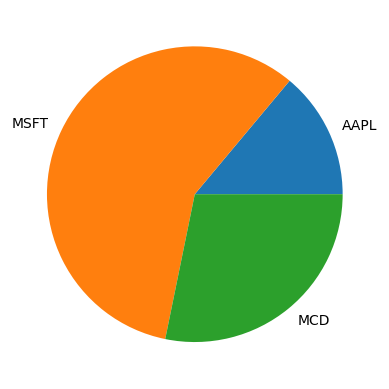

In [52]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array(weights)
mylabels = my_assets

plt.pie(y, labels = mylabels)
plt.show()

In [53]:
# 4_stocks= ["JPM", "GS", "MSFT", "WMT"]
# 6_stocks= ["JPM", "GS", "MSFT", "AAPL", "WMT", "MCD"]
# 8_stocks= ["JPM", "GS", "MSFT", "AAPL", "KO", "WMT", "MCD", "NKE"]
# 10_stocks=["JPM", "GS", "MSFT", "AAPL", "KO", "WMT", "DIS", "BA", "MCD", "NKE"]

## MPT CODE to benchmark 

In [54]:
!pip install yfinance

In [55]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

In [56]:
NUM_TRADING_DAYS = 252 #252*5 cosnidered previously, now I'm just taing for 1 year
NUM_PORTFOLIOS = 10000
stocks = ["JPM", "GS", "MSFT", "AAPL", "WMT", "MCD"]

In [57]:
start_date = '2011-01-01' # YY/MM/DD
end_date = '2015-12-31'   # YY/MM/DD

In [58]:
def download_data():
    stocks_data = yf.download(stocks, start = '2011-1-1', end = '2015-12-31')['Adj Close']
    # stocks_data.head()
    return pd.DataFrame(stocks_data)

In [59]:
def show_data(data):
    data.plot(figsize=(8, 5))
    plt.show()

# show_data(data)

In [60]:
def calculate_return(data):
    log_return = np.log(data / data.shift(1))
    return log_return[1:]

In [61]:
def show_statistics(returns):
    print(returns.mean() * NUM_TRADING_DAYS)
    print(returns.cov() * NUM_TRADING_DAYS)

In [62]:
def show_mean_variance(returns, weights):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    print('Expected portfolio mean: ', portfolio_return)
    print('Expected portfolio volatility: ', portfolio_volatility)
    print("sharpe ratio of a portfolio is ", portfolio_return/portfolio_volatility)

In [63]:
def show_portfolios(returns, volatilities):
    plt.figure(figsize=(8, 5))
    plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.show()

In [64]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

In [65]:
def generate_portfolios(returns):
    portfolio_means = []
    portfolio_risks = []
    portfolio_weights = []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(stocks))
        w /= np.sum(w)
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

In [66]:
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))

    return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])

In [67]:
def min_function_sharpe(weights, returns):
    return -statistics(weights, returns)[2]

In [68]:
def optimize_portfolio(weights, returns):
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(len(stocks)))
    return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns, method='SLSQP',
                                 bounds=bounds, constraints=constraints)


In [69]:
def print_optimal_portfolio(optimum, returns):
    print('Optimal Portfolio: ', optimum['x'].round(3))
    print('Expected return, volatility and sharpe ratio: ', statistics(optimum['x'].round(3), returns))


In [70]:
def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
    plt.figure(figsize=(8, 5))
    plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
    plt.grid(True)
    plt.xlabel('Expected Volatility')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
    plt.show()


[*********************100%***********************]  6 of 6 completed


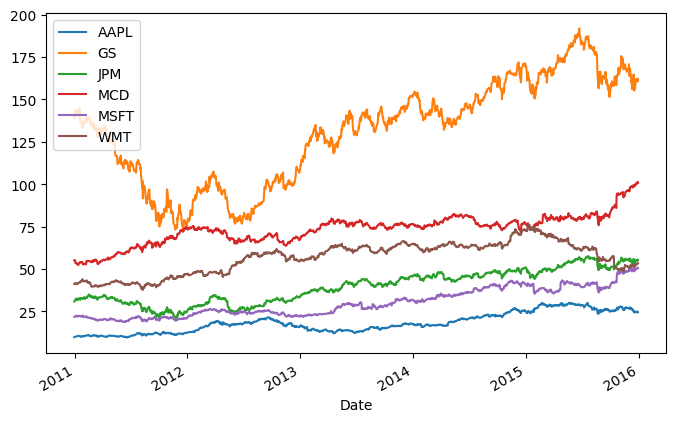

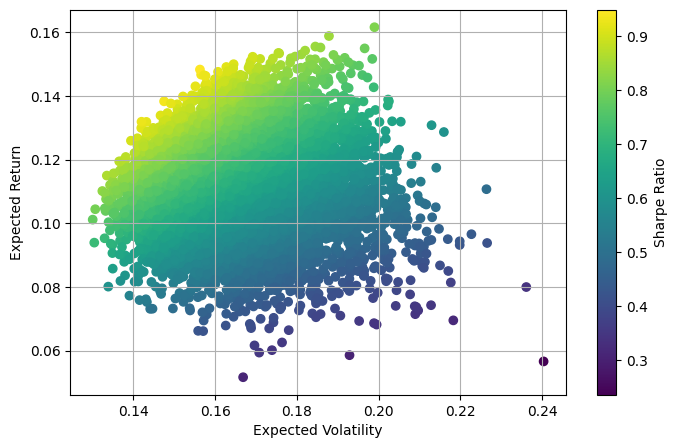

Optimal Portfolio:  [0.229 0.    0.    0.532 0.239 0.   ]
Expected return, volatility and sharpe ratio:  [0.14667675 0.15025067 0.97621362]


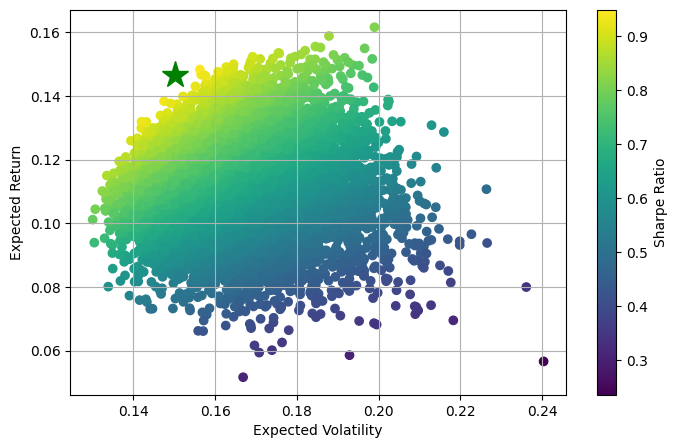

In [71]:
if __name__ == '__main__':
    # print(download_data())
    dataset = download_data()
    show_data(dataset)
    log_daily_returns = calculate_return(dataset)
    # show_statistics(log_daily_returns)
    # show_mean_variance(log_daily_returns, [0.1, 0.2, 0.3, 0.2, 0.1, 0.1])
    pweights, means, risks = generate_portfolios(log_daily_returns)
    show_portfolios(means, risks)
    optimum = optimize_portfolio(pweights, log_daily_returns)
    print_optimal_portfolio(optimum, log_daily_returns)
    show_optimal_portfolio(optimum, log_daily_returns, means, risks)

In [72]:
risk_ret_dict_of_quantum

{'returns': 14.671269016328708,
 'risk': 14.840868169061341,
 'sharpe_ratio': 0.9885721542162745}

In [75]:
!pip install pyportfolioopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 1.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 7.8 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.3/191.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 5.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 7.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.6 MB/s eta 0:00:00a 0:00:01


In [77]:
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 4.3 MB/s eta 0:00:0000:0100:01


## TO Benchmark with Pypfopt


[*********************100%***********************]  6 of 6 completed
AAPL    0.201775
GS      0.029782
JPM     0.123904
MCD     0.128587
MSFT    0.183335
WMT     0.053947
dtype: float64


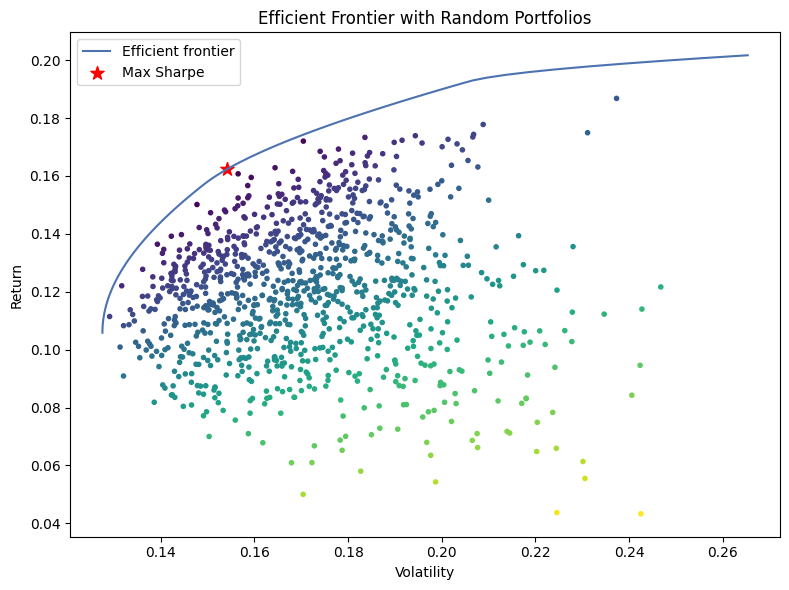

OrderedDict([('AAPL', 0.26145), ('GS', 0.0), ('JPM', 0.0), ('MCD', 0.47144), ('MSFT', 0.26712), ('WMT', 0.0)])
Expected annual return: 16.23%
Annual volatility: 15.42%
Sharpe ratio: 0.92


In [78]:
stocks_df = yf.download(stocks, start = '2011-1-1', end = '2015-12-31')['Adj Close']
stocks_df.head()


# !pip install pyportfolioopt


# from pandas_datareader.data import DataReader
import yfinance as yf
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import copy
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns



mu = expected_returns.mean_historical_return(stocks_df)
S = risk_models.sample_cov(stocks_df)
print(mu)

def plot_cum_returns(data, title):    
    daily_cum_returns = 1 + data.dropna().pct_change()
    daily_cum_returns = daily_cum_returns.cumprod()*100
    fig = px.line(daily_cum_returns, title=title)
    return fig
    
fig_cum_returns = plot_cum_returns(stocks_df, 'Cumulative Returns of Individual Stocks Starting with $100')
# fig_cum_returns.show()

corr_df = stocks_df.corr().round(2) # round to 2 decimal places
fig_corr = px.imshow(corr_df, text_auto=True, title = 'Correlation between Stocks')
# fig_corr.show()

def plot_efficient_frontier_and_max_sharpe(mu, S):  
    # Optimize portfolio for maximal Sharpe ratio 
    ef = EfficientFrontier(mu, S)
    fig, ax = plt.subplots(figsize=(8,6))
    ef_max_sharpe = copy.deepcopy(ef)
    plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)
    # Find the max sharpe portfolio
    ef_max_sharpe.max_sharpe(risk_free_rate=0.02)
    ret_tangent, std_tangent, _ =   ef_max_sharpe.portfolio_performance()
    ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r",     label="Max Sharpe")
# Generate random portfolios
    n_samples = 1000
    w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
    rets = w.dot(ef.expected_returns)
    stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
    sharpes = rets / stds
    ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")
# Output
    ax.set_title("Efficient Frontier with Random Portfolios")
    ax.legend()
    plt.tight_layout()
    plt.show()
    
plot_efficient_frontier_and_max_sharpe(mu, S)

ef = EfficientFrontier(mu, S)
ef.max_sharpe(risk_free_rate=0.02)
weights = ef.clean_weights()
print(weights)

expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance()
print('Expected annual return: {}%'.format((expected_annual_return*100).round(2)))
print('Annual volatility: {}%'.format((annual_volatility*100).round(2)))
print('Sharpe ratio: {}'.format(sharpe_ratio.round(2)))